# 10 階層ベイズモデル -GLMMのベイズモデル化-

In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
using CSV
using DataFrames
using Distributions
using ForneyLab
using LaTeXStrings
@everywhere using Mamba
using Plots
using QuadGK
using StatsBase
using StatsFuns
using StatsPlots

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl


## 10.1 例題 : 個体差と生存種子数 (個体差あり)

In [3]:
df = CSV.read("data/section10a.csv")
disallowmissing!(df)

,id,y
,Int64,Int64
1,1,0
2,2,2
3,3,7
4,4,8
5,5,1
6,6,7
7,7,8
8,8,8
9,9,1


青丸は観測データ, 白丸は生存確率0.504の二項分布. 二項分布では観測データのばらつきが説明できていない

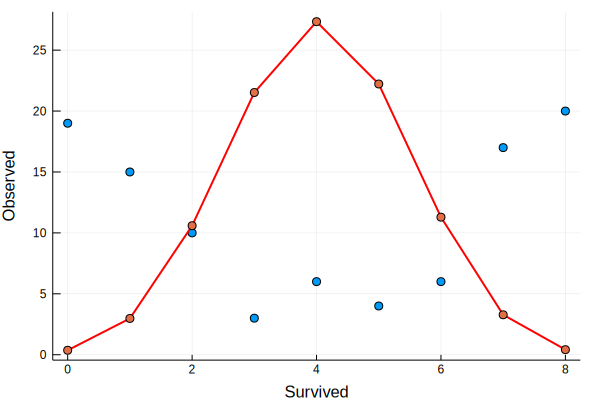

In [4]:
scatter(sort(unique(df.y)), counts(df.y), label = "")
ys = pdf.(Binomial(8, 0.504), 0:8) .* 100
plot!(0:8, ys, linecolor = :red, linewidth = 2,
    marker = 4, label = "",
    xlabel = "Survived", ylabel = "Observed")

## 10.3 階層ベイズモデルの推定・予測
### 10.3.1 階層ベイズモデルのMCMCサンプリング
### モデルの作成
\begin{align}
y_i & \sim \text{Binomial}(q_i, 8) \\
\text{logit}(q_i) & = \beta + r_i \\
\beta & \sim \text{Normal}(0, 100^2) \\
r_i & \sim \text{Normal}(0, \tau^2) \\
\tau & \sim \text{Uniform}(0, 10000)
\end{align}

In [5]:
model = Model(
    y = Stochastic(1,
        (beta, r, N) ->
            UnivariateDistribution[
                (q = invlogit(beta + r[i]);
                Binomial(8, q)) for i in 1:N
            ],
        false
    ),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1, s -> Normal(0, s), false),
    
    s = Stochastic(() -> Uniform(0, 10000)),
)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


### モデルの図示

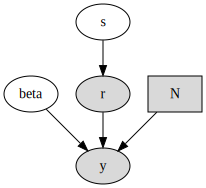

In [6]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model)))

### データの設定

In [7]:
data = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
)

Dict{Symbol,Any} with 2 entries:
  :N => 100
  :y => [0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0]

### 初期値の設定

In [8]:
inits = [
    Dict{Symbol, Any}(
        :y => df.y,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[0.00205757, -0.151606, 0.0379579, -0.0590775, -0.116071, -0.101337, 0.142455, 0.0634165, 0.0788594, 0.00523404  …  0.0680909, -0.0696825, 0.0556264, -0.0828538, -0.0809501, 0.0843182, 0.0663835, -0.117129, -0.0638682, 0.127819])   
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[0.0138491, 0.0171365, -0.226244, 0.126629, -0.0452747, -0.0645128, -0.0955373, -0.0544726, -0.120713, 0.0097657  …  0.015369, -0.0566648, 0.00724056, -0.152868, 0.189088, -0.162398, -0.264535, -0.0901711, 0.170612, 0.0920631])     
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[-0.0501006, -0.0160857, -0.0238438, 0.0279196, -0.133213, -0.118566, -0.184185, 0.0834467, 0.0459128, 0.0507443  …  0.0328075, -0.0475969, 0.128041, -0.0706101, -0.245466, -0.0687166, -0.0888294, -0.054268

### MCMCサンプル方法の設定
NUTSを使うと遅くなってしまったので、AMWGを使用

In [9]:
scheme = [
    AMWG(:r, 1),
    Slice(:s, 1.0, Mamba.Univariate),
    Slice(:beta, 1.0, Mamba.Univariate),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:r]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Distributions.Univariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                      

### MCMCサンプリング
サンプリングは21000回実施し, burn-inの数は1000, 10飛ばしの結果の記録を3チェイン行うので、サンプルの数は(21000-1000)/10*3=6000個

In [10]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 21000, burnin = 1000, thin = 10, chains = 3)

MCMC Simulation of 21000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [2:35:16 of 2:35:21 remaining]
      From worker 3:	Chain 2:   0% [2:49:06 of 2:49:10 remaining]
      From worker 4:	Chain 3:   0% [2:52:44 of 2:52:49 remaining]
      From worker 2:	Chain 1:  10% [0:02:36 of 0:02:54 remaining]
      From worker 4:	Chain 3:  10% [0:02:40 of 0:02:58 remaining]
      From worker 3:	Chain 2:  10% [0:02:41 of 0:02:58 remaining]
      From worker 2:	Chain 1:  20% [0:01:59 of 0:02:29 remaining]
      From worker 4:	Chain 3:  20% [0:02:01 of 0:02:31 remaining]
      From worker 3:	Chain 2:  20% [0:02:01 of 0:02:32 remaining]
      From worker 2:	Chain 1:  30% [0:01:38 of 0:02:20 remaining]
      From worker 3:	Chain 2:  30% [0:01:39 of 0:02:22 remaining]
      From worker 4:	Chain 3:  30% [0:01:39 of 0:02:22 remaining]
      From worker 2:	Chain 1:  40% [0:01:22 of 0:02:16 remaining]
      From worker 3:	Chain 2:  40% [0:01:22 of 0:02:16 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[4.29233 -0.376588; 2.86642 -0.569039; … ; 3.59962 -0.330658; 3.69607 -0.00863698]

[2.56185 -0.276291; 3.2523 0.0128457; … ; 3.2062 -0.14639; 2.96679 -0.233993]

[3.43378 0.458816; 2.87968 0.299706; … ; 3.26039 0.225559; 2.97437 0.221677]

### サンプリング結果を表示

In [11]:
describe(sim)

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

Empirical Posterior Estimates:
         Mean        SD      Naive SE       MCSE       ESS   
   s 3.036130501 0.3641827 0.0047015787 0.008071283 2000.0000
beta 0.045058887 0.3334117 0.0043043265 0.009464885 1240.8834

Quantiles:
        2.5%       25.0%       50.0%       75.0%      97.5%  
   s  2.3856925  2.78342928 3.009303617 3.26089495 3.79796890
beta -0.6141518 -0.18449777 0.044850955 0.26642342 0.71281963



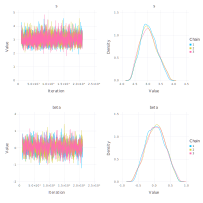

In [12]:
p = Mamba.plot(sim, legend = true)
Mamba.draw(p, nrow = 2, ncol = 2)

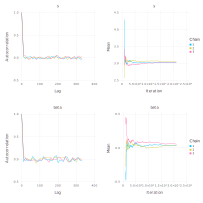

In [13]:
p = Mamba.plot(sim, [:autocor, :mean], legend=true)
Mamba.draw(p, nrow = 2, ncol = 2)

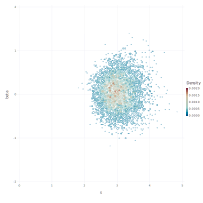

In [14]:
p = Mamba.plot(sim, :contour)
Mamba.draw(p, nrow = 1, ncol = 1)

### 10.3.2 階層ベイズモデルの事後分布推定と予測
$p(y \mid \beta, r)p(r \mid s)$を求める関数

In [15]:
function f_gaussian_binorm(alpha, x, size, fixed, sd)
   pdf(Binomial(size, logistic(fixed + alpha)), x) * pdf(Normal(0, sd), alpha)
end

f_gaussian_binorm (generic function with 1 method)

$p(y \mid \beta, s) = \int_{-\infty}^\infty p(y \mid \beta, r)p(r \mid s)dr$を求める関数. 
実際は$\int_{-10s}^{10s} p(y \mid \beta, r)p(r \mid s)dr$を求めている

In [16]:
function d_gaussian_binorm(x, fixed, sd)
    quadgk(y -> f_gaussian_binorm(y, x, 8, fixed, sd), -sd * 10, sd * 10)[1]
end

d_gaussian_binorm (generic function with 1 method)

各パスに対し, $y = 0, \ldots, 8$ に対して $p(y \mid \beta, s)$ を評価する.

In [17]:
posterior = map((x, y) -> d_gaussian_binorm.(0:8, x, y), sim[:, [:beta], :].value[:], sim[:, [:s], :].value[:])

6000-element Array{Array{Float64,1},1}:
 [0.311826, 0.0917238, 0.0593716, 0.0487099, 0.0456026, 0.0476036, 0.0564813, 0.0838018, 0.25488]
 [0.262219, 0.123104, 0.0861674, 0.0716073, 0.0660826, 0.0664654, 0.0734326, 0.0932066, 0.157716]
 [0.215888, 0.112963, 0.083203, 0.071595, 0.0680248, 0.0703617, 0.0801588, 0.105881, 0.191925]   
 [0.253661, 0.110701, 0.0772739, 0.0649021, 0.0609358, 0.0628048, 0.0719954, 0.0977465, 0.19998] 
 [0.278608, 0.115757, 0.0789473, 0.0652293, 0.0603781, 0.0613498, 0.0691797, 0.0917625, 0.178788]
 [0.27689, 0.121492, 0.0834468, 0.0688082, 0.0633003, 0.063674, 0.0706342, 0.0907826, 0.160972]  
 [0.277691, 0.125145, 0.0861487, 0.0708521, 0.0648618, 0.064773, 0.071056, 0.0894779, 0.149994]  
 [0.260906, 0.122563, 0.0858826, 0.0714484, 0.0660115, 0.0664816, 0.0735771, 0.0936463, 0.159483]
 [0.214124, 0.110447, 0.0812684, 0.0700635, 0.0667964, 0.0694371, 0.0797164, 0.106801, 0.201346] 
 [0.22906, 0.120758, 0.0881363, 0.0749276, 0.0701877, 0.0713402, 0.0793451, 0.

各パスに対して、$P(X=y)=p(y \mid \beta, s)\ \text{for}\ y = 0, \ldots, 8$というCategorical distributionから100個体のサンプリングを行い, $y$ごとに出現回数を数える. 横方向は各サンプリング, 縦方向は$y = 0, \ldots, 8$の出現回数に該当

In [18]:
population_samples = hcat(map(x -> fit(Histogram, rand(Distributions.Categorical(x), 100) .- 1, 0:9).weights, posterior)...)

9×6000 Array{Int64,2}:
 31  24  21  29  34  31  28  36  13  …  18   7  13  15  18  19  20  23  20
  7   8  13  14  10  13  11   8  11      7  11  10   6  15  14  12  13  15
  8  17   5   5   6  13   9   9  11     10   6   8   6  11   8   7  12   4
  3   8   8   7   5   3  10   8   4      9   4   9   5   6   6   8   5   7
  4   7   4   5  10   6   4   8   7      5  12   6  11   4   4   9   6   6
  4   4   6  10   8   2   3   4   7  …  13   5   1   5   8   6   4   7   6
  9   5   8   4   7   9  11   3   7      3  15  11  13   6   5   9   6   4
 11  13   8  11   7   6   8   8  16     15  15  18  14  10   5   7   9  16
 23  14  27  15  13  17  16  16  24     20  25  24  25  22  33  24  19  22

$y$毎に出現回数の2.5%, 50%, 97.5%点を計算

In [19]:
function quantile_sample(r)
    map(x -> quantile(population_samples[x, :], r), 1:9)
end
quantile_sample_0025 = quantile_sample(0.025)
quantile_sample_0975 = quantile_sample(0.975)
quantile_sample_median = quantile_sample(0.5)

9-element Array{Float64,1}:
 21.0
 10.0
  8.0
  7.0
  6.0
  7.0
  8.0
 11.0
 22.0

### 生存種子数の予測分布
各 $y$ における中央値, 及び95%区間の領域を表示する

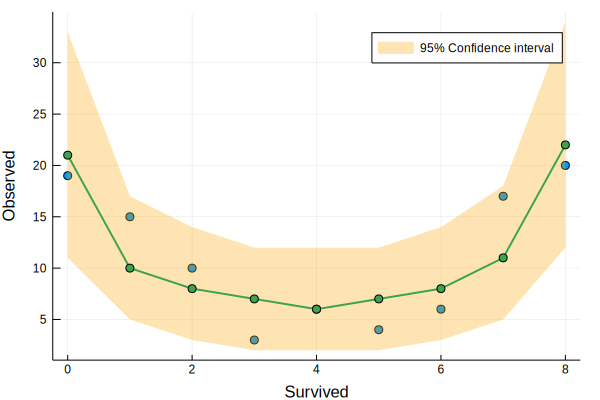

In [20]:
scatter(sort(unique(df.y)), counts(df.y), label = "")
Plots.plot!(0:8, quantile_sample_0025, lw = 0, 
    fillrange = quantile_sample_0975,
    fillalpha = 0.3, fillcolor = :orange,
    label = "95% Confidence interval")
Plots.plot!(0:8, quantile_sample_median, linewidth = 2, marker = 4, label = "",
            xlabel = "Survived", ylabel = "Observed")

## 10.5 個体差 + 場所差の階層ベイズモデル

In [21]:
df2 = CSV.read("data/section10b.csv")
disallowmissing!(df2)

,id,pot,f,y
,Int64,String,String,Int64
1,1,A,C,6
2,2,A,C,3
3,3,A,C,19
4,4,A,C,5
5,5,A,C,0
6,6,A,C,19
7,7,A,C,4
8,8,A,C,8
9,9,A,C,12


In [22]:
marker_dict = Dict(
    "A" => :circle,
    "B" => :ltriangle,
    "C" => :star5,
    "D" => :diamond,
    "E" => :dtriangle,
    "F" => :xcross,
    "G" => :star4,
    "H" => :utriangle,
    "I" => :rect,
    "J" => :rtriangle
)

Dict{String,Symbol} with 10 entries:
  "B" => :ltriangle
  "A" => :circle
  "I" => :rect
  "J" => :rtriangle
  "C" => :star5
  "D" => :diamond
  "G" => :star4
  "E" => :dtriangle
  "F" => :xcross
  "H" => :utriangle

### 個体ごとの表示
赤線は無処理、青線は堆肥処理した個体の平均

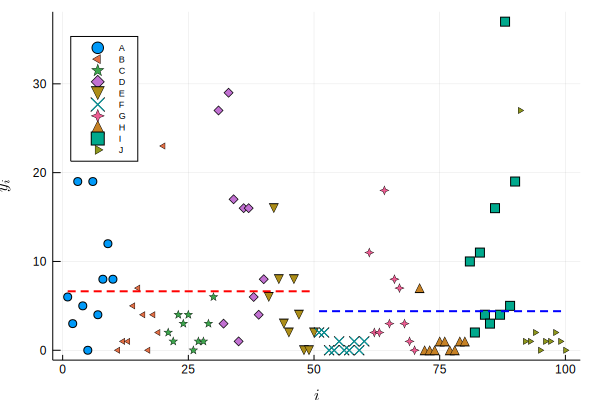

In [23]:
plt = Plots.plot()
for k in sort(collect(keys(marker_dict)))
    df_k = df2[df2[:pot] .== k, :]
    scatter!(df_k.id, df_k.y, label = k, markershape = marker_dict[k],
        legend = :topleft, legendfontsize = 6, xlabel = L"i", ylabel = L"y_i")
end
plot!(1:50, fill(mean(df2[1:50, :].y), 50), linestyle = :dash, linewidth = 2, linecolor = :red, label = "")
plot!(51:100, fill(mean(df2[51:100, :].y), 50), linestyle = :dash, linewidth = 2, linecolor = :blue, label = "")
plt

### 植木鉢毎に箱ひげ図として図示

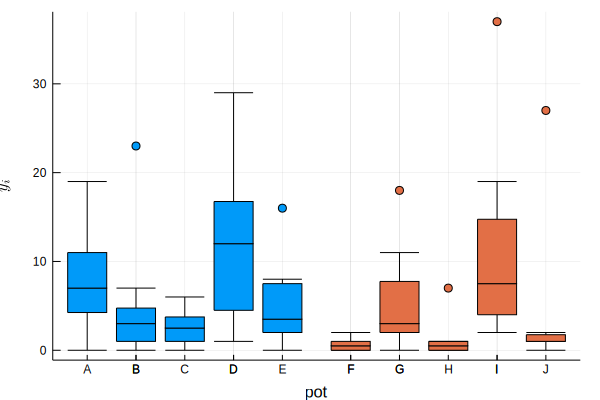

In [24]:
boxplot(df2[1:50, :].pot, df2[1:50, :].y, label = "")
boxplot!(df2[51:100, :].pot, df2[51:100, :].y, label = "", xlabel = "pot", ylabel = L"y_i")

### GLMM化したポアソン回帰
個体$i$の種子数$y_i$を平均$\lambda_i$のポアソン回帰
\begin{align}
p(y_i \mid \lambda_i) = \frac{\lambda_i^{y_i}\exp(-\lambda_i)}{y_i!}
\end{align}
で表現し, 平均種子数は切片$\beta_1$, 堆肥処理の有無を表す因子型の説明変数$f_i$の係数$\beta_2$, 個体$i$の効果$r_i$と植木鉢$j$の効果$t_{j(i)}$で
\begin{align}
\log \lambda_i = \beta_1 + \beta_2 f_i + r_i + t_{j(i)}
\end{align}
で表現.

\begin{align}
y_i & \sim \text{Poisson}(\lambda_i), \ i = 1, \ldots, 100 \\
\log \lambda_i & = \beta_1 + \beta_2 f_i + r_i + t_{j(i)} \\
\beta_1, \beta_2 & \sim \text{Normal}(0, 100) \\
r_i & \sim \text{Normal}(0, s_r^2) \\
t_j & \sim \text{Normal}(0, s_t^2), j = 1,\ldots, 10 \\
s_r, s_t & \sim \text{Uniform}(0, 10000)
\end{align}

In [41]:
model2 = Model(
    
    y = Stochastic(1,
        (beta1, beta2, f, r, t, pot, N_r) ->
            UnivariateDistribution[
                (lambda = exp(beta1 + beta2 * f[i] + r[i] + t[pot[i]]);
                Poisson(lambda)) for i in 1:N_r
            ],
        false
    ),
    
    r = Stochastic(1, s_r -> Normal(0, s_r), false),
    
    t = Stochastic(1, s_t -> Normal(0, s_t), false),
    
    beta1 = Stochastic(() -> Normal(0, 100)),
    beta2 = Stochastic(() -> Normal(0, 100)),
    
    s_r = Stochastic(() -> Uniform(0, 10000)),
    s_t = Stochastic(() -> Uniform(0, 10000)),
)

Object of type "Model"
-------------------------------------------------------------------------------
beta2:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
s_r:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s_t:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
t:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
beta1:
A monitored node of type "ScalarS

### モデルの図示

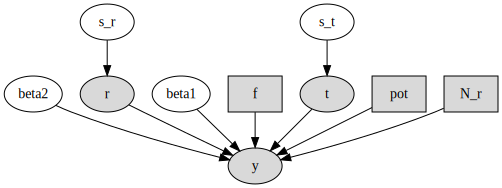

In [42]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model2)))

### 入力データの設定

In [43]:
pot_dict = Dict(string(y) => x for (x, y) in enumerate("ABCDEFGHIJ"))
f_dict = Dict("C" => 0, "T" => 1)
data2 = Dict{Symbol, Any}(
    :y => df2.y,
    :N_r => length(df2.y),
    :N_t => length(unique(df2.pot)),
    :pot => [pot_dict[x] for x in df2.pot],
    :f => [f_dict[x] for x in df2.f],
)

Dict{Symbol,Any} with 5 entries:
  :f   => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  :N_t => 10
  :y   => [6, 3, 19, 5, 0, 19, 4, 8, 12, 8  …  27, 1, 1, 2, 0, 1, 1, 2, 1, 0]
  :N_r => 100
  :pot => [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  10, 10, 10, 10, 10, 10, 10, 10, 10,…

### 初期値の設定

In [44]:
inits2 = [
    Dict{Symbol, Any}(
        :y => df2.y,
        :beta1 => 0.0,
        :beta2 => 0.0,
        :r => rand(Normal(0, 0.1), data2[:N_r]),
        :t => rand(Normal(0, 0.1), data2[:N_t]),
        :s_r => 1.0,
        :s_t => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta2=>0.0,:s_r=>1.0,:y=>[6, 3, 19, 5, 0, 19, 4, 8, 12, 8  …  27, 1, 1, 2, 0, 1, 1, 2, 1, 0],:s_t=>1.0,:beta1=>0.0,:r=>[0.0281958, -0.218379, -0.131702, 0.211161, -0.0244951, -0.00303516, -0.065852, -0.0340402, -0.00776199, 0.116901  …  0.144302, -0.0773741, -0.0442896, -0.124643, 0.0989084, -0.0517736, -0.324482, -0.0690094, 0.148209, -0.130585],:t=>[0.00446952, -0.0801666, -0.0445559, 0.0135504, -0.0803392, -0.0224721, 0.112747, -0.0112015, 0.0899669, 0.0811658])
 Dict(:beta2=>0.0,:s_r=>1.0,:y=>[6, 3, 19, 5, 0, 19, 4, 8, 12, 8  …  27, 1, 1, 2, 0, 1, 1, 2, 1, 0],:s_t=>1.0,:beta1=>0.0,:r=>[-0.0627858, -0.139043, -0.0786207, 0.0246329, 0.0746473, -0.00589989, -0.0359263, 0.146555, 0.104829, -0.155804  …  -0.109837, -0.0573962, 0.0859016, 0.0953985, -0.0960537, 0.00987312, -0.0110408, -0.0460972, 0.197062, -0.0449478],:t=>[0.164413, -0.0496899, -0.0217261, -0.187718, -0.219303, 0.191841, 0.106886, -0.125639, -0.0477882, 0.234083])    
 Dict(:be

In [45]:
scheme2 = [
    AMWG([:r], 0.1), 
    AMWG([:t], 0.1),
    Slice([:s_r, :s_t], 0.1, Mamba.Univariate), 
    Slice([:beta1, :beta2], 1.0, Mamba.Univariate)
]

4-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:r]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:t]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), false))
│   %2 = (%1)(model, blo

In [46]:
setsamplers!(model2, scheme2)
sim2 = mcmc(model2, data2, inits2, 22000, burnin = 2000, thin = 10, chains = 3)

MCMC Simulation of 22000 Iterations x 3 Chains...

      From worker 3:	Chain 1:   0% [0:09:24 of 0:09:24 remaining]
      From worker 4:	Chain 2:   0% [0:08:48 of 0:08:48 remaining]
      From worker 2:	Chain 3:   0% [0:10:46 of 0:10:46 remaining]
      From worker 4:	Chain 2:  10% [0:02:24 of 0:02:40 remaining]
      From worker 3:	Chain 1:  10% [0:02:25 of 0:02:41 remaining]
      From worker 2:	Chain 3:  10% [0:02:27 of 0:02:43 remaining]
      From worker 4:	Chain 2:  20% [0:02:08 of 0:02:40 remaining]
      From worker 3:	Chain 1:  20% [0:02:09 of 0:02:41 remaining]
      From worker 2:	Chain 3:  20% [0:02:10 of 0:02:43 remaining]
      From worker 4:	Chain 2:  30% [0:01:52 of 0:02:39 remaining]
      From worker 3:	Chain 1:  30% [0:01:52 of 0:02:41 remaining]
      From worker 2:	Chain 3:  30% [0:01:54 of 0:02:42 remaining]
      From worker 4:	Chain 2:  40% [0:01:36 of 0:02:41 remaining]
      From worker 3:	Chain 1:  40% [0:01:37 of 0:02:42 remaining]
      From worker 2:	Chai

Object of type "ModelChains"

Iterations = 2010:22000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[1.25212 0.940284 1.159 -0.482915; 1.17291 0.739501 1.15317 -0.289135; … ; 2.17323 2.18238 1.04768 -3.20061; 2.2098 2.40615 1.0301 -3.31511]

[0.957255 1.71957 1.04092 -2.09348; 1.02841 1.60324 1.13207 -2.15297; … ; 2.36553 3.60307 1.13682 0.152091; 2.37979 3.22857 1.12538 0.353617]

[0.758929 0.730677 0.986301 -0.0524152; 0.734935 0.760485 0.930958 -0.201294; … ; 1.06153 1.40719 1.05534 -0.845085; 0.919049 1.49059 1.03362 -0.5723]

### 事後分布を確認する
$\beta_2$の95%区間を見ると、堆肥処理の効果はなさそう

In [47]:
describe(sim2)

Iterations = 2010:22000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE       ESS   
  s_t  1.0197051 0.35458461 0.0045776676 0.028626812 153.42418
beta1  1.3768939 0.51684077 0.0066723856 0.046321072 124.49626
  s_r  1.0154092 0.11299772 0.0014587943 0.003767955 899.34840
beta2 -0.8047238 0.76291068 0.0098491345 0.063248738 145.49353

Quantiles:
          2.5%       25.0%       50.0%       75.0%       97.5%  
  s_t  0.52053558  0.77418470  0.95681213  1.19216766 1.99383355
beta1  0.46439878  1.03274662  1.35480218  1.65758209 2.53192191
  s_r  0.80815596  0.93589618  1.00979547  1.08862177 1.25452790
beta2 -2.45493055 -1.23087486 -0.76764045 -0.34303802 0.63767799



In [48]:
p = Mamba.plot(sim2, legend = true);

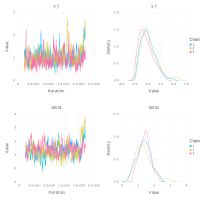

In [49]:
Mamba.draw(p[:, 1:2], nrow = 2, ncol = 2)

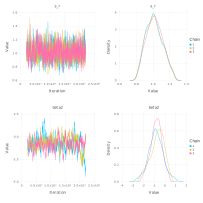

In [50]:
Mamba.draw(p[:, 3:4], nrow = 2, ncol = 2)

In [51]:
p = Mamba.plot(sim2, [:autocor, :mean], legend=true);

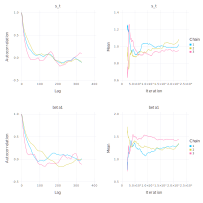

In [52]:
Mamba.draw(p[:, 1:2], nrow = 2, ncol = 2)

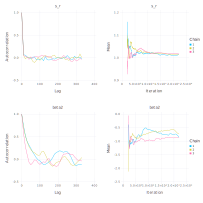

In [53]:
Mamba.draw(p[:, 3:4], nrow = 2, ncol = 2)